# Clasificación de Abulones con Redes Neuronales

## 1. Carga y Exploración de Datos

En esta sección cargamos el dataset y examinamos su estructura:
- Veremos el tamaño y las primeras filas.
- Revisaremos tipos de datos y valores faltantes.
- Analizaremos la distribución de la variable objetivo.
- Visualizaremos correlaciones entre características.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargar dataset
data = pd.read_csv("abalone.csv")
print(f"Dataset shape: {data.shape}")
display(data.head())

Dataset shape: (4177, 9)


,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# Información del dataset
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           4177 non-null   object 
 1   LongestShell   4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


None

In [4]:
# Distribución de clases
print(data['Type'].value_counts())

Type
M    1528
I    1342
F    1307
Name: count, dtype: int64


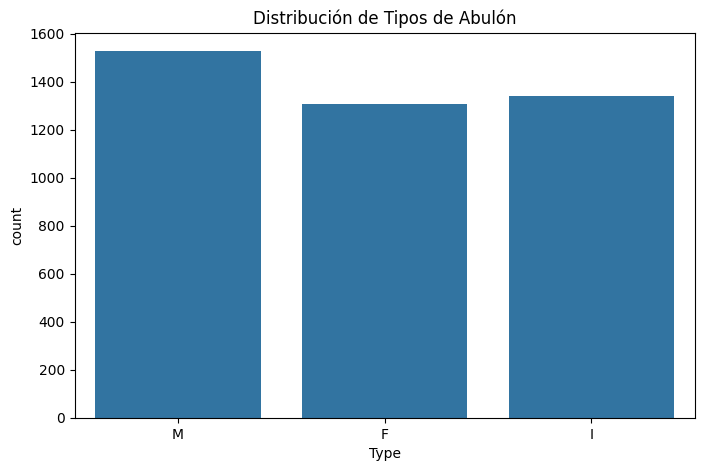

In [5]:
# Visualización
plt.figure(figsize=(8, 5))
sns.countplot(x='Type', data=data)
plt.title('Distribución de Tipos de Abulón')
plt.show()

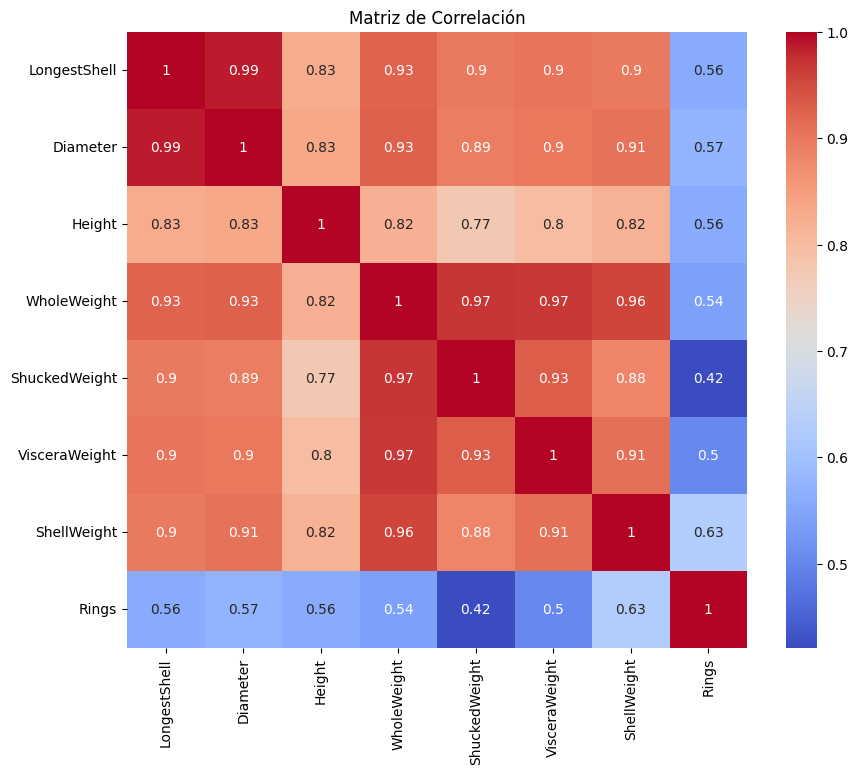

In [6]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
corr_matrix = data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

## 2. Preprocesamiento de Datos

- **One-hot encoding**: Transformar la variable categórica en columnas binarias para evitar ordinalidad artificial.
- **División estratificada**: Mantener proporciones de clases en entrenamiento, validación y prueba.
- **Normalización**: Escalar características para que tengan media 0 y desviación estándar 1, lo cual mejora la convergencia.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
# One-hot encoding
data_encoded = pd.get_dummies(data, columns=['Type'], prefix='', prefix_sep='')

# Separar X e y
X = data_encoded.drop(['F', 'I', 'M'], axis=1)
y = data_encoded[['F', 'I', 'M']]

# División en entrenamiento, validación y prueba
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Normalización
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Entrenamiento: {X_train.shape}")
print(f"Validación: {X_val.shape}")
print(f"Prueba: {X_test.shape}")

Entrenamiento: (3341, 8)
Validación: (418, 8)
Prueba: (418, 8)


## 3. Construcción del Modelo de Red Neuronal

- Capas densas con activación ReLU para aprender representaciones no lineales.
- **Dropout** para prevenir sobreajuste.
- Capa final con **softmax** para salida de probabilidades en clasificación multiclase.
- Compilación con **Adam** y **categorical_crossentropy**.

In [9]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()

c:\Users\Dell\PyhtonIA\DL Deep Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,755 (10.76 KB)

 Trainable params: 2,755 (10.76 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento del Modelo

- Uso de **EarlyStopping**: detiene si la pérdida de validación no mejora en varias épocas.
- Entrenamos con lotes (batch) para estabilizar gradientes.

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4301 - loss: 1.0212 - precision: 0.5186 - recall: 0.1654 - val_accuracy: 0.5144 - val_loss: 0.8508 - val_precision: 0.6765 - val_recall: 0.2751
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5227 - loss: 0.8794 - precision: 0.6452 - recall: 0.3100 - val_accuracy: 0.5335 - val_loss: 0.8392 - val_precision: 0.6498 - val_recall: 0.3373
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5488 - loss: 0.8602 - precision: 0.6365 - recall: 0.3297 - val_accuracy: 0.5383 - val_loss: 0.8356 - val_precision: 0.6854 - val_recall: 0.2919
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5504 - loss: 0.8626 - precision: 0.6456 - recall: 0.3341 - val_accuracy: 0.5455 - val_loss: 0.8325 - val_precision: 0.6907 - val_recall: 0.3206
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5469 - loss: 0.8615 - precision: 0.6472 - recall: 0.3351 - val_accuracy: 0.5574 - val_los

## 5. Evaluación del Modelo

- Graficar curvas de **precisión** y **pérdida** para detectar sobreajuste.
- Calcular métricas en el conjunto de prueba.
- **Matriz de confusión** y **reporte de clasificación** para analizar el desempeño por clase.

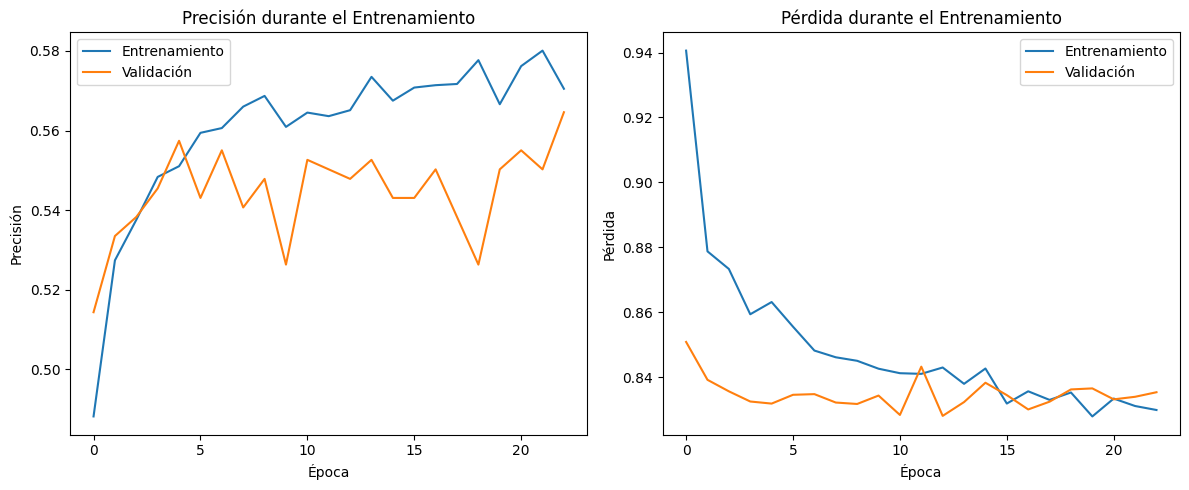

Métricas en prueba: [0.8577249050140381, 0.5693780183792114, 0.6896551847457886, 0.38277512788772583]
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


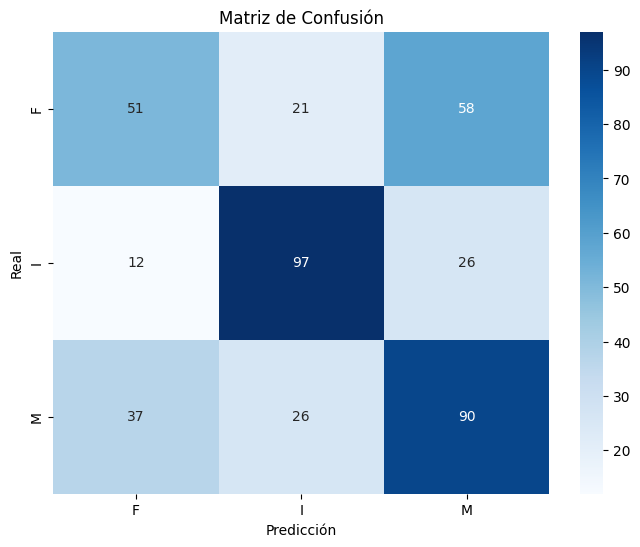

              precision    recall  f1-score   support

  Hembra (F)       0.51      0.39      0.44       130
 Infante (I)       0.67      0.72      0.70       135
   Macho (M)       0.52      0.59      0.55       153

    accuracy                           0.57       418
   macro avg       0.57      0.57      0.56       418
weighted avg       0.57      0.57      0.56       418



In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Gráficas
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluación en prueba
test_metrics = model.evaluate(X_test, y_test, verbose=0)
print(f"Métricas en prueba: {test_metrics}")

# Matriz de confusión y reporte
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test.values, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['F','I','M'], yticklabels=['F','I','M'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=['Hembra (F)','Infante (I)','Macho (M)']))

## 6. Interpretación y Uso del Modelo

- Función para predecir nuevos ejemplos, aplicando la misma normalización.
- Guardado del modelo para futuras inferencias.

In [12]:
# Función de predicción
def predecir_tipo_abulon(caracteristicas):
    array = np.array([caracteristicas])
    array_scaled = scaler.transform(array)
    probabilidades = model.predict(array_scaled)[0]
    clases = {0: 'Hembra (F)', 1: 'Infante (I)', 2: 'Macho (M)'}
    return {clases[i]: float(probabilidades[i]) for i in range(3)}

# Ejemplo
ejemplo = [0.455, 0.365, 0.095, 0.514, 0.2245, 0.101, 0.15, 15]
print(predecir_tipo_abulon(ejemplo))

# Guardar modelo
model.save('modelo_abulones.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


c:\Users\Dell\PyhtonIA\DL Deep Learning\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


{'Hembra (F)': 0.37411609292030334, 'Infante (I)': 0.17144586145877838, 'Macho (M)': 0.4544380307197571}


 ## Intentos de mejora:

In [13]:
# Aumentar la capacidad del modelo
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.4),  # Mayor dropout para regularización
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'), # Una capa más
    tf.keras.layers.Dense(3, activation='softmax')
])

# Añadir callbacks para ajuste fino
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,     # Reduce el Learning Rate a la mitad cuando se estanca
    patience=3,     # Espera 3 épocas sin mejora
    min_lr=1e-7     # Tasa mínima permitida
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,    # Mayor paciencia
    restore_best_weights=True
)

c:\Users\Dell\PyhtonIA\DL Deep Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Cambiamos el optimizador con una tasa de aprendizaje más baja
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reducido de 0.001 a 0.0001

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Entrenamiento con más épocas
history = model.fit(
    X_train, y_train,
    epochs=100,  # Más épocas para aprendizaje lento
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler],  # Añadir scheduler
    verbose=1
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5837 - loss: 0.8376 - precision: 0.6843 - recall: 0.3583 - val_accuracy: 0.5670 - val_loss: 0.8275 - val_precision: 0.6500 - val_recall: 0.3110 - learning_rate: 1.9531e-07
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5664 - loss: 0.8293 - precision: 0.6828 - recall: 0.3610 - val_accuracy: 0.5670 - val_loss: 0.8275 - val_precision: 0.6500 - val_recall: 0.3110 - learning_rate: 1.9531e-07
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5419 - loss: 0.8507 - precision: 0.6513 - recall: 0.3262 - val_accuracy: 0.5670 - val_loss: 0.8275 - val_precision: 0.6500 - val_recall: 0.3110 - learning_rate: 1.9531e-07
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5608 - loss: 0.8390 - precision: 0.6624 - recall: 0.3328 - val_accuracy: 0.5694 - val_loss: 0.8275 - val_precision: 0.6500 - val_recall: 0.3110 - learning_rate: 1.9531e-07
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 